<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> Explicación del modelo con mejores resultados </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Ver el Log
import logging, verboselogs

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquete para cargar el modelo cargado
from joblib import load

# Paquete permutation importance
from sklearn.inspection import permutation_importance

# Paquete randomForest
from sklearn.ensemble import RandomForestClassifier

# Grafico del peso de variables en la predicción.
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence

## Importar DataSets
Importamos el dataset Evaluación de la casuística cuyo modelo ha obtenido mejores resultados. El dataset de Evaluacion que tenemos que importar es en el que se haya aplicado un **Oversampling con reduccion de atributos**

In [2]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## Evaluacion

In [3]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_over_dis.csv',Filename = '/tmp/eval_over_dis.csv')

In [4]:
#Leemos el fichero y lo metemos en un dataframe.
evalDis = pd.read_csv('/tmp/eval_over_dis.csv', dtype={'rank':'category'})

In [5]:
print (evalDis.shape)

(80000, 9)


In [6]:
evalDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type_TRANSFER,newbalanceOrig,isFraud
0,8.318578e+06,8.318578e+06,8.574436e+06,8.318578e+06,9,20,0,0.0,1.0
1,3.207200e+05,3.207200e+05,1.368527e+06,3.207200e+05,29,5,0,0.0,1.0
2,2.480947e+06,0.000000e+00,0.000000e+00,2.480947e+06,6,13,1,0.0,1.0
3,3.607461e+04,0.000000e+00,0.000000e+00,3.607461e+04,8,19,1,0.0,1.0
4,2.727997e+04,0.000000e+00,0.000000e+00,2.727997e+04,18,7,1,0.0,1.0


In [7]:
pd.value_counts(evalDis['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [8]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_over_dis.csv

## Cargamos el modelo


In [9]:
model = load("Fraud_Model.joblib")
model

RandomForestClassifier(max_depth=20, max_features=0.9, n_estimators=200)

Aplicamos el modelo al dataframe de evaluación:

In [10]:
evaly = evalDis.loc[:, 'isFraud'].values
evalX = evalDis.drop(columns=['isFraud']).values
features = evalDis.drop(columns=['isFraud']).columns.tolist()

In [11]:
print(evaly.shape)
print(evalX.shape)

(80000,)
(80000, 8)


In [12]:
# Aplicamos el modelo
model.score(evalX, evaly)

0.9981875

Ahora vamos a utilizar la libreria permutation_importance para poder saber qué variables son más predictivas que otras.

In [15]:
r = permutation_importance(model, evalX, evaly,n_repeats=10, random_state=0)

In [16]:
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
             print(f"{evalDis.columns[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

newbalanceOrig0.070 +/- 0.000
balanceOrig0.064 +/- 0.001
amount  0.037 +/- 0.001
newbalanceDest0.009 +/- 0.000
hours_day0.005 +/- 0.000
day     0.004 +/- 0.000
balanceDest0.002 +/- 0.000
type_TRANSFER0.002 +/- 0.000


In [13]:
feature_dupla = [('balanceOrig','balanceDest')]

In [14]:
feature_names = ['balanceOrig','balanceDest','newbalanceDest','amount','day','hours_day','type_TRANSFER','newbalanceOrig']

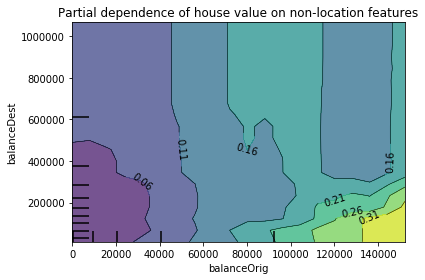

In [65]:
plot_partial_dependence(model, evalX, feature_dupla, feature_names,
                        n_jobs=3, grid_resolution=20) 

fig = plt.gcf()
plt.title('Partial dependence of house value on non-location features')
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()

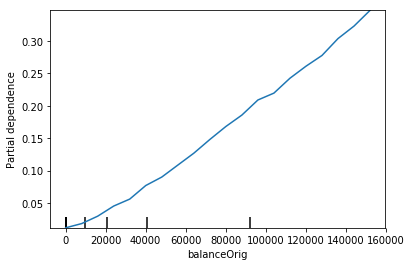

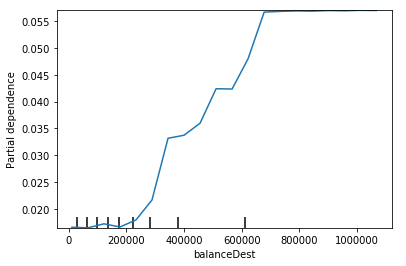

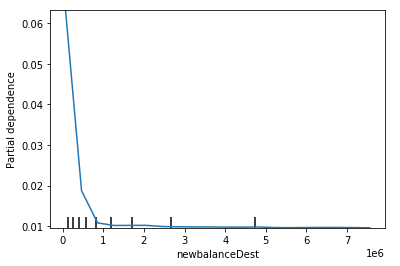

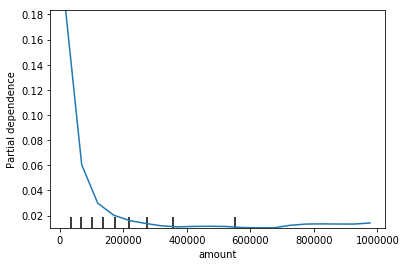

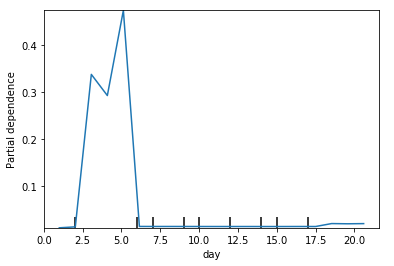

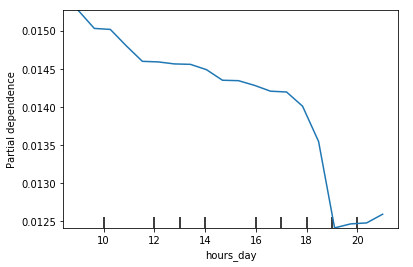

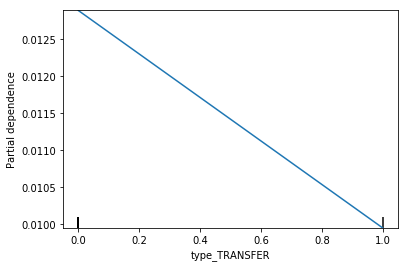

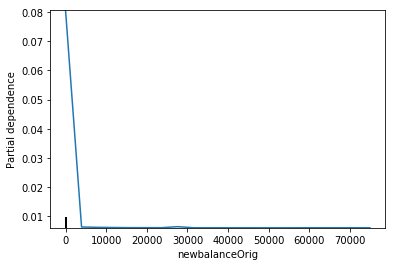

In [63]:
for i in range(len(feature_names)):
    name=[]
    name = [feature_names[i]]
    if name == ['newbalanceDest']:
        plot_partial_dependence(model, evalX, name, feature_names,n_jobs=3, grid_resolution=20) 
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    else:
        plot_partial_dependence(model, evalX, name, feature_names,n_jobs=3, grid_resolution=20) 